In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import nbodypy as npy

from galpy import potential
from galpy.util import bovy_conversion,bovy_plot

from scipy.ndimage import gaussian_filter

from scipy import optimize

import scipy.integrate as integrate

mcon=222288.47
vcon=220.0/bovy_conversion.velocity_in_kpcGyr(vo=220.0,ro=8.0)

r0=8.
v0=220.

ts=np.linspace(0.,2./bovy_conversion.time_in_Gyr(ro=r0,vo=v0),100)

#Scaling relations so VIA LACTEA potential can be modelled as NFW component of MWPotential2014
RscaleT =  1.27318814858
MscaleT =  2.06384847299
VscaleT =  1.27318820452

rvirial=295.5735153741678


In [2]:
def plot_rmax_vmax(Mmin=1e5,Mmax=1e12,
                   conc=lambda m: 10.**(1.025-0.097*np.log10(m*0.671)),plot=True,
                   **kwargs):
    ms= np.logspace(np.log10(Mmin),np.log10(Mmax),201)/1e12
    rmax= np.empty_like(ms)
    vmax= np.empty_like(ms)
    for ii,m in enumerate(ms):
        nfwp= potential.NFWPotential(mvir=m,conc=conc(m),H=0.671*100,overdens=104.2,wrtcrit=True,ro=8.,vo=220.)
        try:
            rmax[ii]= nfwp.rmax(quantity=False)
            vmax[ii]= nfwp.vmax(quantity=False)
            raise
        except:
            rmax[ii]= 2.1625815870646098349*nfwp.a*nfwp._ro
            vmax[ii]= nfwp.vcirc(2.1625815870646098349*nfwp.a,quantity=False)
    if plot:
        kwargs['marker']= kwargs.get('marker','None')
        kwargs['ls']= kwargs.get('ls','-')
        plt.loglog(vmax,rmax,**kwargs)
        plt.xlabel(r'$v_\mathrm{max}\,(\mathrm{km\,s}^{-1})$')    
        plt.ylabel(r'$r_\mathrm{max}\,(\mathrm{kpc})$')
        
    return vmax,rmax

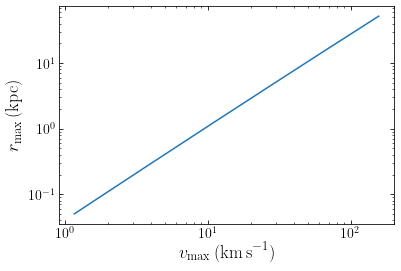

In [3]:
vmax_cdm,rmax_cdm=plot_rmax_vmax()

In [4]:
#What about other properties at infall?

def get_infall_times(ra,verbose=False):
    
    zdata=np.loadtxt('stepToTimeVL2.txt',skiprows=3)
    zshift=np.flip(zdata[:,2],axis=0)
    tshift=np.flip(zdata[:,3],axis=0)

    x=np.loadtxt('progX.txt')*40000.0
    y=np.loadtxt('progY.txt')*40000.0
    z=np.loadtxt('progZ.txt')*40000.0    
        
    dx=x-x[-2]
    dy=y-y[-2]
    dz=z-z[-2]
    dist=np.sqrt(dx**2.+dy**2.+dz**2.)
    #Scale factor
    a=1./(1.+zshift)
    
    for i in range(0,len(a)):
        dist[:,i]*=a[i]
    
    rtide=np.loadtxt('progRtidal.txt')
    mtide=np.loadtxt('progMtidal.txt')
    rvmax=np.loadtxt('progRvmax.txt')
    vmax=np.loadtxt('progVmax.txt')

    rscale=rtide[-2,0]/rtide[-2,:]
    rscale[np.isinf(rscale)]=-1.
    
    dist*=rscale    
    dist=np.delete(dist,-2,0)
    
    mtide=np.delete(mtide,-2,0)
    rtide=np.delete(rtide,-2,0)
    rvmax=np.delete(rvmax,-2,0)
    vmax=np.delete(vmax,-2,0)
            
    rapo=np.repeat(ra,len(zshift)).reshape(len(dist),len(zshift))
    
    z_infall=[]
    t_infall=[]
    rt_infall=[]
    m_infall=[]
    rv_infall=[]
    vmax_infall=[]
    
    for i in range(0,len(dist)):
        indx=(dist[i,:] > 0.) * (dist[i,:] <= ra[i])
        
        if np.sum(indx)>0. and rvmax[i][indx][-1] > 0.:
            z_infall.append(zshift[indx][-1])
            t_infall.append(13.755-tshift[indx][-1])
            m_infall.append(mtide[i][indx][-1])
            rt_infall.append(rtide[i][indx][-1])
            rv_infall.append(rvmax[i][indx][-1])
            vmax_infall.append(vmax[i][indx][-1])
            
        else:
            z_infall.append(-1000.)
            t_infall.append(-1000.)
            m_infall.append(-1000.)
            rt_infall.append(-1000.)
            rv_infall.append(-1000.)
            vmax_infall.append(-1000.)
            
    if verbose:
        return np.array(z_infall),np.array(t_infall),np.array(m_infall),np.array(rt_infall),np.array(rv_infall),np.array(vmax_infall)
    else:
        return np.array(z_infall),np.array(t_infall)

In [5]:
#Check settings for subhalo
def f(x):
    return np.log(1.+x)-x/(1+x)

def fb(r,rh,c,epsilon):
    #fbound < 1.79/f (c) * (ε/rs,0)*(rh/rs,0)
    
    return (1.79/f(c))*(epsilon/r)*(rh/r)

def check_subhalo(phalo,rhalo,mhalo=None,debug=False,mdm=None,wrtcrit=False):
    
    if mhalo==None:
        mhalo=phalo*(4.0*np.pi*((rhalo*1000.0)**3.))
    
    if mdm is None:
   
        #If we want to evolve the cluster to 1% dissolution
        #fsub < 0.32(Nacc/1000)**−0.8 ,
        Nacc=1000.0*(0.01**(-1./0.8))/0.32

        #Set softening to ε = 0.05 (Nacc/10^5)^−1/3 in NBODY units
        epsilon=0.05*((Nacc/1.0e5)**(-1./3.))
        
    else:
        Nacc=mhalo/mdm
        
        if mdm==4.1e3:
            epsilon=40.0/1000.0
        elif mdm==3.0e4:
            epsilon=37.0/1000.0

    #Setup initial halo
    sub_halo_m=mhalo
    sub_halo_r=rhalo
    sub_halo=potential.NFWPotential(amp=mhalo/bovy_conversion.mass_in_msol(ro=r0,vo=v0),a=sub_halo_r/r0,ro=r0,vo=v0,wrtcrit=wrtcrit)
    sub_halo_m200=sub_halo.mass(200./r0,0.0,ro=r0,vo=v0)
    
    print('MHALO, RHALO = ',mhalo,rhalo)
    
    try:
        sub_halo_mvir=sub_halo.mvir()
        sub_halo_rv=sub_halo.rvir()
        sub_halo_c=sub_halo.conc()
        sub_halo_rh=sub_halo_r*3.6*((sub_halo_c/10)**.63)
    except:
        #raise 
        print('HALO NOT VIRIALISED',Nacc,sub_halo_m,sub_halo_r,sub_halo_m200)
        return -1,-1,mhalo

    if mdm is None:
        #Scale epsilon to N-body units by assuming RBAR=scale radius
        epsilon*=sub_halo_r
    
        #Check force resolution: 
        f_b=fb(sub_halo_r,sub_halo_rh,sub_halo_c,epsilon)

        #To get to 1%,  should be decrease epsilon?
        while f_b>0.01:
            epsilon/=2.
            f_b=fb(sub_halo_r,sub_halo_rh,sub_halo_c,epsilon)

    if debug:
        print('rho rs m N epsilon m r rv c rh m200')
        print(phalo,rhalo,mhalo,Nacc,epsilon,sub_halo_m,sub_halo_r,sub_halo_rv,sub_halo_c,sub_halo_rh,sub_halo_m200)
        #print('rho rs m N epsilon m r c rh m200')
        #print(phalo,rhalo,mhalo,Nacc,epsilon,sub_halo_m,sub_halo_r,sub_halo_c,sub_halo_rh,sub_halo_m200)

    return Nacc,epsilon,sub_halo

In [6]:
#Get virial radius using GALPY definition

def get_rvir(pot):
    overdens=200.
    H=70.0 #(km/s) / Mpc
    H/=(1000000.0) #(km/s) / pc
    Om=0.3
    Grav=4.302e-3 #pc (km/s)^2 / Msun
    
    rhocrit=3.0*(H**2.)/(8.0*np.pi*Grav) # Msun/pc^3
    
    r=np.linspace(1,1000.,10000)
    for i in range(1,len(r)):
        
        r1=r[i-1]
        r2=r[i]
        
        rho1=pot.mass(r1/8.,0.0,ro=8.,vo=220.)/(4.0*np.pi*((r1*1000.0)**3.)/3.)
        rho2=pot.mass(r2/8.,0.0,ro=8.,vo=220.)/(4.0*np.pi*((r2*1000.0)**3.)/3.)

        if rho2 <= rhocrit*overdens:
            r_v=npy.interpolate([r1,rho1],[r2,rho2],y=rhocrit*overdens)
            break
        else:
            r_v=r2
        
    return r_v

def galpy_get_rvir(pot):
    r0=8.
    v0=220.
    overdens=200.
    H=70.0 #(km/s) / Mpc
    H/=(1000000.0) #(km/s) / pc
    Om=0.3
    Grav=4.302e-3 #pc (km/s)^2 / Msun
    
    rhocrit=3.0*(H**2.)/(8.0*np.pi*Grav) # Msun/pc^3
    
    x= optimize.brentq(lambda y: pot.mass(y/r0,0.0,ro=r0,vo=v0)/(4.0*np.pi*((y*1000.0)**3.)/3.)-overdens*rhocrit,
                           0.,500.)
    
    return x*r0

In [7]:
def make_halo(pot,rmax,n=100000,nsim='',galaxy=False,debug=False,lowres=False):
    
    r0=8.
    v0=220.
    
    r_v=pot.rvir()
    r_s=pot.a*pot._ro 
    c=pot.conc()
    mvir=pot.mvir()
    r_t=rmax
        
    #mtot=pot.dens(1./r0,0.0,ro=r0,vo=v0)*(1000.0**3.)/rho_nfw(1.,r_s,r_t,1.)
    mtot=pot.mass(r_t/r0,0.0,ro=r0,vo=v0)/menc(r_t,r_s,r_t,1.)

    #print('MTOT = ',mtot)

    
    #Find number of halos you need to have n within rmax
    if lowres:
        mmax=menc(r_t,r_s,r_t,mtot)
    else:
        mmax=menc(10.0*r_t,r_s,r_t,mtot)
    nhalo=mmax/(menc(rmax,r_s,r_t,mtot)/float(n))
    
    rad=np.logspace(np.log10(0.001*rmax),np.log10(rmax),100)
    rho=rho_nfw(rad,r_s,r_t,mtot)
    
    mass=[]
    for r in rad:
        mass.append(menc(r,r_s,r_t,mtot))
        
        
    if galaxy:
        command=('mkhalo out=dmsub%s.nemo nbody=%i model=NFW r_s=%f M=%f r_t=%f WD_units=t accname=\'PowSphwCut+MiyamotoNagai\', accpars=\'0,1001.7912681201547,1.8,1.9#0,306770.41839070275,3.0,0.28\'' % (nsim,nhalo,r_s,mmax,-1.*r_t))    
    else:
        command=('mkhalo out=dmsub%s.nemo nbody=%i model=NFW r_s=%f M=%f r_t=%f WD_units=t' % (nsim,nhalo,r_s,mmax,-1.*r_t))    

    if debug:
        print(command)
        
    #print(r0,v0,r_v,r_s,c,mvir,r_t,mmax)


        
    return rad,rho,mass,command

    
def rho_nfw(r,r_s,r_t,mtot):    
    
    r_c=0.0
    
    #NFW:
    inner=1.
    eta=1.
    outer=3.
    
    x =np.sqrt(r**2.+r_c**2.)/r_s
    
    if False:
        trunc=1./np.cosh(r/r_t)
    else:
        trunc=2./(1/np.cosh(r/r_t)+np.cosh(r/r_t))
    
    amp=mtot*trunc
    
    model=(x**inner)*((x**eta+1.)**((outer-inner)/eta))
         
    return amp/model

def dM(r,r_s,r_t,mtot):
    return 4.0*np.pi*(r**2.)*rho_nfw(r,r_s,r_t,mtot)

def menc(r,r_s,r_t,mtot):
    return integrate.quad(dM, 0, r,args=(r_s,r_t,mtot))[0]
    
    

In [8]:
mw=potential.MWPotential2014
nfw=potential.NFWPotential(a=2.,normalize=0.35, ro=r0, vo=v0)

rv=nfw.rvir()
rs=nfw.a*r0 
c=nfw.conc()
mvir=nfw.mvir()

print(rv,rs,c,mvir,nfw._ro,nfw.mass(100.0/r0,0.0,ro=r0,vo=v0),nfw._amp)

295.5735153741678 16.0 18.47334471088549 882577388165.0 8.0 488786920282.0 4.85223053353


In [9]:
#Full z=0 snapshot
data=np.loadtxt('vltwosubs.txt',skiprows=3)
print(np.argwhere(data[:,1]==0.))

indx=(data[:,1]>0)

i_d=data[:,0][indx]
D=data[:,1][indx] #kpc
vmax_peak=data[:,2][indx] #km/s
vmax0=data[:,3][indx] #km/s
rvmax0=data[:,4][indx] #kpc
mtidal0=data[:,5][indx] #Msun
rtidal0=data[:,6][indx] #kpc
x,y,z=data[:,7][indx],data[:,8][indx],data[:,9][indx] #kpc
vx,vy,vz=data[:,10][indx],data[:,11][indx],data[:,12][indx] #km/s
m300=data[:,13][indx] #Msun
m600=data[:,14][indx] #Msun


indx=np.invert(indx)
i_d_mw=data[:,0][indx]
D_mw=data[:,1][indx] #kpc
vmax_peak_mw=data[:,2][indx] #km/s
vmax_mw=data[:,3][indx] #km/s
rvmax_mw=data[:,4][indx] #kpc
mtidal_mw=data[:,5][indx] #Msun
rtidal_mw=data[:,6][indx] #kpc
x_mw,y_mw,z_mw=data[:,7][indx],data[:,8][indx],data[:,9][indx] #kpc
vx_mw,vy_mw,vz_mw=data[:,10][indx],data[:,11][indx],data[:,12][indx] #km/s
m300_mw=data[:,13][indx] #Msun
m600_mw=data[:,14][indx] #Msun

[[20046]]


In [10]:
np.amin(vmax0),np.amax(vmax0),np.amin(vmax_peak),np.amax(vmax_peak)

(0.21243200000000001, 41.0107, 4.00021, 118.101)

8247


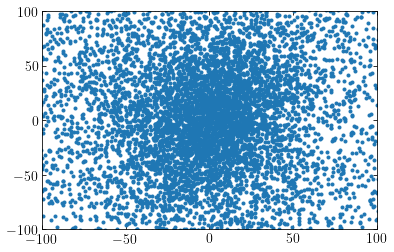

In [11]:
plt.plot(x,y,'.')
plt.xlim(-100,100)
plt.ylim(-100,100)
r=np.sqrt(x*x+y*y+z*z)
print(np.sum(r<rv))

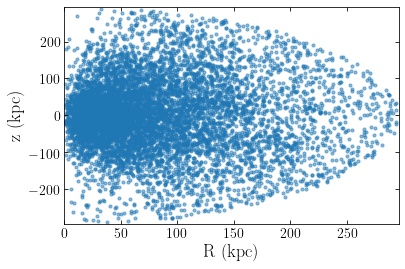

In [12]:
rcyl=np.sqrt(x*x+y*y)
indx=(r<rv)


plt.scatter(rcyl[indx],z[indx],s=10.,alpha=0.5)

plt.xlabel(r'$\rm R \ (kpc)$')
plt.ylabel(r'$\rm z \ (kpc)$')
plt.xlim(0,rv)
plt.ylim(-rv,rv)
plt.show()
plt.close()

In [13]:
Nacc=1000.0*(0.01**(-1./0.8))/0.32

#Set softening to ε = 0.05 (Nacc/10^5)^−1/3 in NBODY units
epsilon=0.05*((Nacc/1.0e5)**(-1./3.))

print(Nacc,epsilon)

988211.7688026185 0.023299861015014262


In [14]:
#Scale radius and density of sub-halos
grav=4.302e-3
rs_sub0=rvmax0/2.16258
ps_sub0=((vmax0/(1.64*rs_sub0*1000.))**2.)/grav


In [15]:
#Setup VL2 galaxy
vl2galaxy=npy.StarCluster(len(i_d),units='realkpc',origin='cluster',center=True)
vl2galaxy.add_stars(x,y,z,vx,vy,vz,id=i_d,m=mtidal0,)
vl2galaxy.add_orbit(0.0,0.0,0.0,0.0,0.0,0.0)
vl2galaxy.key_params()

gamma=1.24
rs=28.1
ps=3.5e-3
amp=ps*(4.0*np.pi*((rs*1000.0)**3.))

#Galpy potential for VL2 galaxy
vl2b=potential.TwoPowerSphericalPotential(amp=amp/bovy_conversion.mass_in_msol(ro=r0,vo=v0),a=rs/r0,alpha=gamma,beta=3.,ro=r0,vo=v0)

print(vl2galaxy.ntot)

20047


In [16]:
print(np.sum(vl2galaxy.r < rv))

8247


In [17]:
#Solve orbits in VL2
os_vl2=npy.initialize_orbits(vl2galaxy)
os_vl2.integrate(ts,vl2b)
ecc_vl2=os_vl2.e()
rp_vl2=os_vl2.rperi()
ra_vl2=os_vl2.rap()
zmax_vl2=os_vl2.zmax()
r_vl2=os_vl2.r()

In [18]:
r_vl2=np.array(r_vl2)
rp_vl2=np.array(rp_vl2)
ra_vl2=np.array(ra_vl2)
ecc_vl2=np.array(ecc_vl2)
zmax_vl2=np.array(zmax_vl2)

In [19]:
np.sum(r_vl2 < rv),np.sum(ra_vl2 < rv),np.sum(r_vl2 < 100.0)

(8247, 7287, 3658)

/usr/local/lib/python3.7/site-packages/amuse/units/quantities.py:1379: RuntimeWarning: divide by zero encountered in true_divide
  return numpy.true_divide(array, other, out)



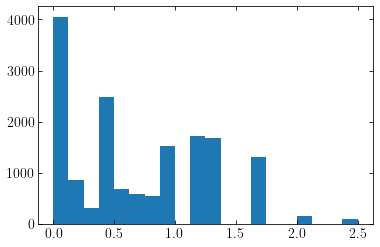

In [20]:
#Get infall times
z_infall,t_infall,mtidal,rtidal,rvmax,vmax=get_infall_times(ra_vl2,verbose=True)

zindx=(z_infall > -500) & (z_infall < 3.)

plt.hist(z_infall[zindx],bins=20)
plt.show()
plt.close()
#Check paper for a comparable plot?

In [21]:
nindx=(mtidal < 0.)

In [22]:
np.sum(nindx),np.sum(zindx)

(4039, 16000)

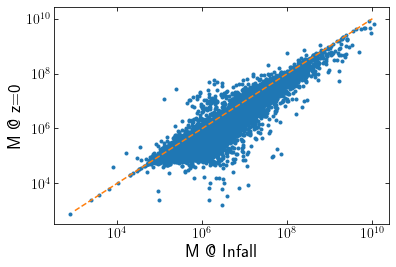

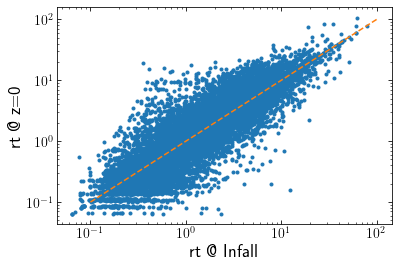

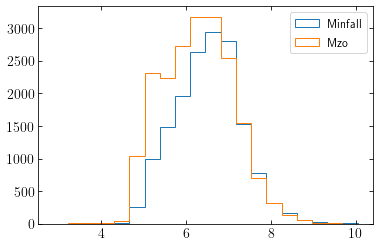

-1.13681423276 0.0793949078629


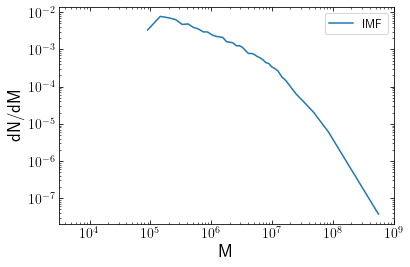

In [23]:
plt.loglog(mtidal,mtidal0,'.')
plt.loglog([1.0e3,1.0e10],[1.0e3,1.0e10],'--')
plt.xlabel('M @ Infall')
plt.ylabel('M @ z=0')

plt.show()

plt.loglog(rtidal,rtidal0,'.')
plt.loglog([1.0e-1,1.0e2],[1.0e-1,1.0e2],'--')
plt.xlabel('rt @ Infall')
plt.ylabel('rt @ z=0')

plt.show()


n,bins,patches=plt.hist(np.log10(mtidal[mtidal>0]),bins=20,histtype='step',label='Minfall')
plt.hist(np.log10(mtidal0[mtidal0>0]),bins=bins,histtype='step',label='Mzo')
plt.legend()

plt.show()
plt.close()

x_mean,x_hist,dx,alpha,ealpha,yalpha,eyalpha=npy.dx_function(mtidal[mtidal>0],nx=40)
plt.loglog(x_mean,dx,label='IMF')
print(alpha,ealpha)
  
plt.xlim(10.0**3.5,10.0**9)
plt.legend()
plt.xlabel('M')
plt.ylabel('dN/dM')
plt.show()

#Colour code by apocentre? If its fully captured it shouldnt be out gaining mass

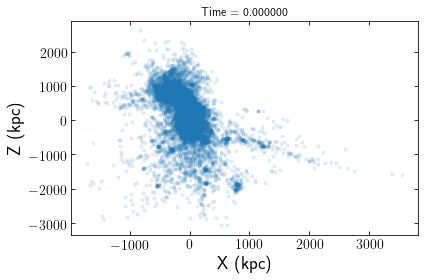

In [24]:
npy.starplot(vl2galaxy,coords='xz')
plt.show()

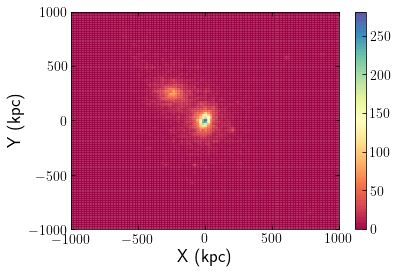

In [25]:
npy.nhist2d(vl2galaxy.x,vl2galaxy.y,xlabel='X (kpc)',ylabel='Y (kpc)',xlim=[-1000.,1000.],ylim=[-1000.,1000.],nbin=100,cmap=plt.cm.Spectral,alpha=0.8)
plt.show()

realkpc cluster
194.280464603


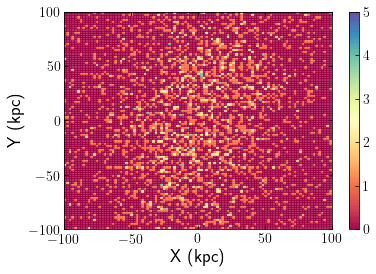

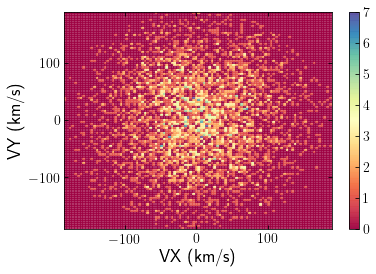

In [26]:
#Set mwgalaxy as subset of subhalos within rvirial kpc and with vmax<90% vesc from Milky Ways NFW Halo

print(vl2galaxy.units,vl2galaxy.origin)
vesc=np.sqrt(2.0*abs(nfw(rvirial/r0,0.0)))
print(vesc)
mwgalaxy=npy.sub_cluster(vl2galaxy,rmax=rvirial,vmax=vesc)

npy.nhist2d(mwgalaxy.x,mwgalaxy.y,xlabel='X (kpc)',ylabel='Y (kpc)',xlim=[-100.,100.],ylim=[-100.,100.],nbin=100,cmap=plt.cm.Spectral,alpha=0.8)
plt.show()

npy.nhist2d(mwgalaxy.vx,mwgalaxy.vy,xlabel='VX (km/s)',ylabel='VY (km/s)',nbin=100,cmap=plt.cm.Spectral,alpha=0.8)
plt.show()

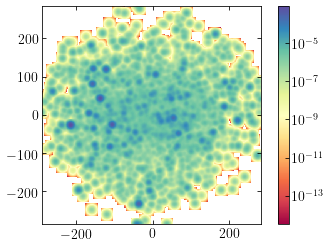

In [27]:
npy.ndens(mwgalaxy.x,mwgalaxy.y,z=mwgalaxy.m,normed=True)
plt.show()

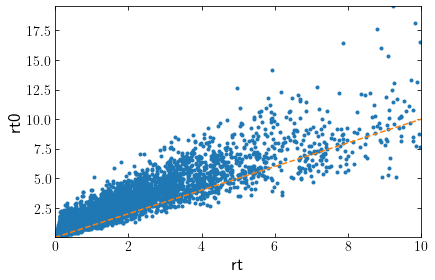

In [28]:
#Calculate tidal radius via paper method using VL2B potential
rt0=(((mtidal0/(4.0*np.pi/3.0))/(2.0*vl2b.dens(D/r0,0.0)))**(1.0/3.0))/1000.

#Compare to rtidal for sub-halos within rvirial
dindx=(D<rvirial)

npy.nplot(rtidal0[dindx],rt0[dindx],xlabel='rt',ylabel='rt0',xlim=(0,10))
plt.plot(np.linspace(0,50,50),np.linspace(0,50,50),'--')
plt.show()
plt.close()

In [29]:
#FIND CRITICAL DENSITY FOR VIRIAL RADIUS:
overdens=200.
H=70.0 #(km/s) / Mpc
Om=0.3
H/=(1000000.0) #(km/s) / pc
Grav=4.302e-3 #pc (km/s)^2 / Msun
rhocrit=3.0*(H**2.)/(8.0*np.pi*Grav) # Msun/pc^3
print(rhocrit*overdens)



2.719174411263204e-05


In [30]:
#Need to scale sub-halos:
x/=RscaleT
y/=RscaleT
z/=RscaleT
D=np.sqrt(x*x+y*y+z*z)

vx/=VscaleT
vy/=VscaleT
vz/=VscaleT
v=np.sqrt(vx*vx+vy*vy+vz*vz)

In [31]:
#Setup galaxy of scaled sub-halos
galaxy=npy.StarCluster(len(i_d),units='realkpc',origin='cluster',center=True)
galaxy.add_stars(x,y,z,vx,vy,vz,id=i_d,m=mtidal,do_key_params=True)
galaxy.add_orbit(0.0,0.0,0.0,0.0,0.0,0.0)

In [32]:
#Setup galaxy for scaled subhalos within 100 kpc and v < vesc
Dmin=0.
Dmax=rvirial
#Dmax=100.0

grav=4.302e-3 #pc (km/s)^2 /Msun
vesc=np.sqrt(2.0*abs(nfw(Dmax/r0,0.0)))
indx=(D>Dmin) * (D <= Dmax)
print(np.sum(indx))
mwD=D[indx]


vesc100=np.sqrt(2.0*abs(nfw(100./r0,0.0)))
indx100=(D>Dmin) * (D <= 100.) * (v <=0.9*vesc100)
print(np.sum(indx100))



9180
4162


In [33]:
mwgalaxy=npy.sub_cluster(galaxy,indx=indx)
#Integrate orbits in NFW
os=npy.initialize_orbits(mwgalaxy)
os.integrate(ts,nfw)
ecc=os.e()
rp=os.rperi()
ra=os.rap()
zmax=os.zmax()
rgc=os.r()
vgc=v[indx]
Dgc=D[indx]
R_gc=os.R()
z0=os.z()

os=npy.initialize_orbits(mwgalaxy)
#Integrate orbits in MWPotential2014
os.integrate(ts,mw)
ecc_mw=os.e()
rp_mw=os.rperi()
ra_mw=os.rap()
zmax_mw=os.zmax()

m=mwgalaxy.m

#Find rs,ps,and rt at infall
rs_sub=rvmax[indx]/2.16258
ps_sub=((vmax[indx]/(1.64*rs_sub*1000.))**2.)/grav
rt_sub=rtidal[indx]
mt_sub=mtidal[indx]
vmax_sub=vmax[indx]
rvmax_sub=rvmax[indx]


print(mwgalaxy.ntot,len(rp),len(rs_sub),len(rt_sub))

rs_sub=np.array(rs_sub)
ps_sub=np.array(ps_sub)
rt_sub=np.array(rt_sub)
mt_sub=np.array(mt_sub)
mt_sub0=np.array(mtidal0[indx])
rt_sub0=np.array(rtidal0[indx])

9180 9180 9180 9180


In [34]:
indx100=(D>Dmin) * (D <= 100.) * (v <=0.9*vesc100)
print(np.sum(indx100))

tindx=(Dgc>Dmin) * (Dgc <= 100.) * (vgc <=0.9*vesc100)
print(np.sum(tindx))

4162
4162


In [35]:
#Solve orbits in VL2B potential
subvl2galaxy=npy.sub_cluster(vl2galaxy,indx=indx)
print(subvl2galaxy.ntot,vl2galaxy.ntot,len(z_infall))

ecc_vl2b=ecc_vl2[indx]
rp_vl2b=rp_vl2[indx]
ra_vl2b=ra_vl2[indx]
zmax_vl2b=zmax_vl2[indx]

z_infallb=z_infall[indx]
t_infallb=t_infall[indx]

print(len(zmax_vl2b))

9180 20047 20047
9180


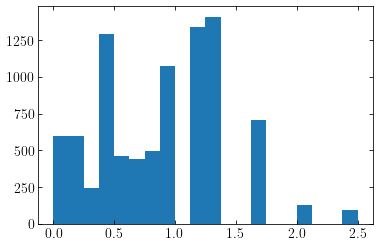

20047 9180 9180
9180 8870


In [36]:
zindx=indx*(z_infall > -500) * (z_infall < 3.)

plt.hist(z_infall[zindx],bins=20)
plt.show()
plt.close()


print(len(z_infall),len(z_infall[indx]),len(z_infallb))
print(np.sum(indx),np.sum(zindx))

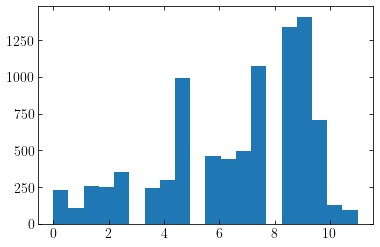

20047 9180 9180
9180 8870


In [37]:
plt.hist(t_infall[zindx],bins=20)
plt.show()
plt.close()


print(len(t_infall),len(t_infall[indx]),len(t_infallb))
print(np.sum(indx),np.sum(zindx))

In [38]:
#Convert parameters to numpy arrays

#Evolution in NFW potential
rp=np.array(rp)
ra=np.array(ra)
rgc=np.array(rgc)
vgc=np.array(vgc)
Dgc=np.array(Dgc)

R_gc=np.array(R_gc)
z0=np.array(z0)
ecc=np.array(ecc)
zmax=np.array(zmax)
m=np.array(m)

#Evolution in MWPotential2014
rp_mw=np.array(rp_mw)
ra_mw=np.array(ra_mw)
ecc_mw=np.array(ecc_mw)
zmax_mw=np.array(zmax_mw)

#Evolution in VL2B
rp_vl2b=np.array(rp_vl2b)
ra_vl2b=np.array(ra_vl2b)
ecc_vl2b=np.array(ecc_vl2b)
zmax_vl2b=np.array(zmax_vl2b)

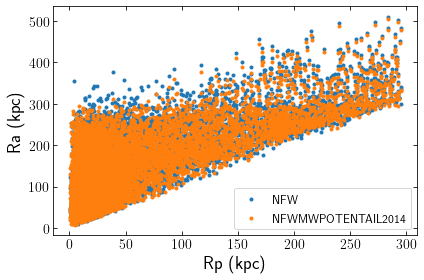

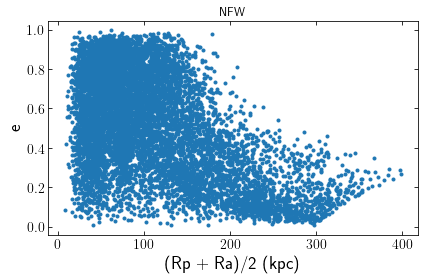

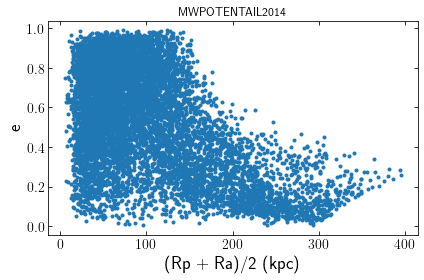

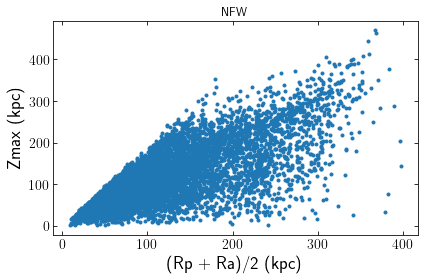

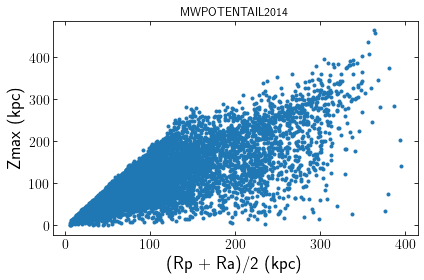

In [39]:

npy.nplot(rp,ra,xlabel='Rp (kpc)',ylabel='Ra (kpc)',label='NFW')
npy.nplot(rp_mw,ra_mw,overplot=True,label='NFWMWPOTENTAIL2014')
plt.legend()
plt.show()
plt.close()

npy.nplot((rp+ra)/2.,ecc,xlabel='(Rp + Ra)/2 (kpc)',ylabel='e',title='NFW')
plt.show()
npy.nplot((rp_mw+ra_mw)/2.,ecc_mw,xlabel='(Rp + Ra)/2 (kpc)',ylabel='e',title='MWPOTENTAIL2014')
plt.show()

npy.nplot((rp+ra)/2.,zmax,xlabel='(Rp + Ra)/2 (kpc)',ylabel='Zmax (kpc)',title='NFW')
plt.show()
npy.nplot((rp_mw+ra_mw)/2.,zmax_mw,xlabel='(Rp + Ra)/2 (kpc)',ylabel='Zmax (kpc)',title='MWPOTENTAIL2014')
plt.show()

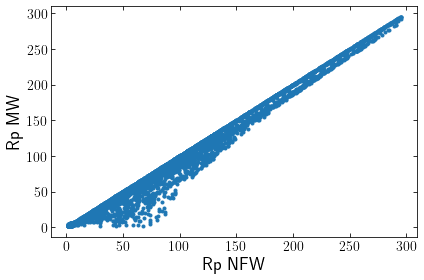

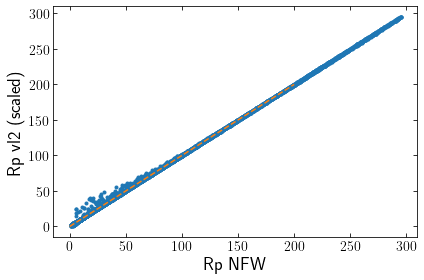

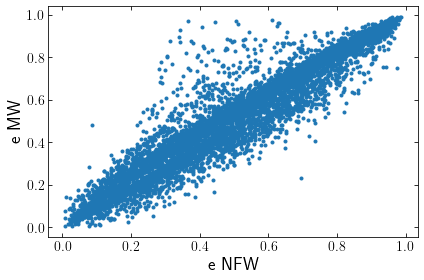

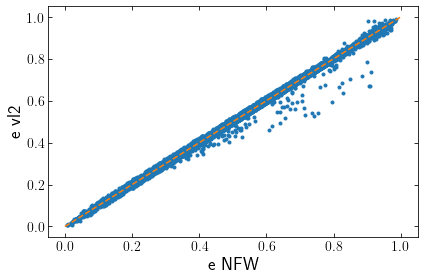

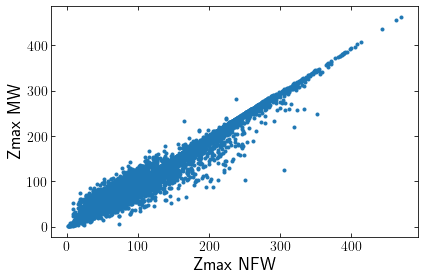

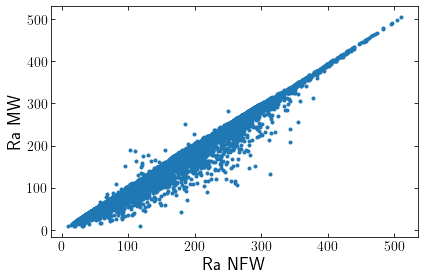

In [40]:
rindx=(rp > 1.) * (rp_mw > 1.)

npy.nplot(rp[rindx],rp_mw[rindx],xlabel='Rp NFW',ylabel='Rp MW')
plt.show()

npy.nplot(rp[rindx],rp_vl2b[rindx]/RscaleT,xlabel='Rp NFW',ylabel='Rp vl2 (scaled)')
npy.nlplot([0,200],[0,200],'--',overplot=True)

plt.show()

npy.nplot(ecc[rindx],ecc_mw[rindx],xlabel='e NFW',ylabel='e MW')
plt.show()

npy.nplot(ecc[rindx],ecc_vl2b[rindx],xlabel='e NFW',ylabel='e vl2')
npy.nlplot([0,1],[0,1],'--',overplot=True)
plt.show()

npy.nplot(zmax[rindx],zmax_mw[rindx],xlabel='Zmax NFW',ylabel='Zmax MW')
plt.show()

npy.nplot(ra[rindx],ra_mw[rindx],xlabel='Ra NFW',ylabel='Ra MW')
plt.show()

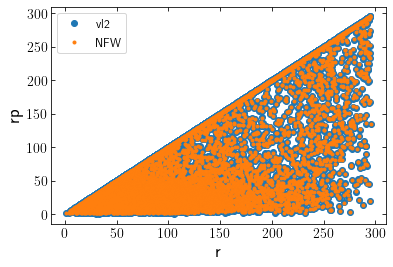

In [41]:
#Check scaling orbit parameters versus orbital integration 
plt.plot(subvl2galaxy.r[rindx]/RscaleT,rp_vl2b[rindx]/RscaleT,'o',label='vl2')
plt.xlabel('r')
plt.ylabel('rp')
plt.plot(mwgalaxy.r[rindx],rp[rindx],'.',label='NFW')
plt.legend()

plt.show()
plt.close()

In [42]:
print(len(ps_sub))
indx1=(ra <= 100.) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)
print(np.sum(indx1))
indx2=(ra > 100.) * (rp<=rvirial) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)
print(np.sum(indx2))

9180
2614
6027


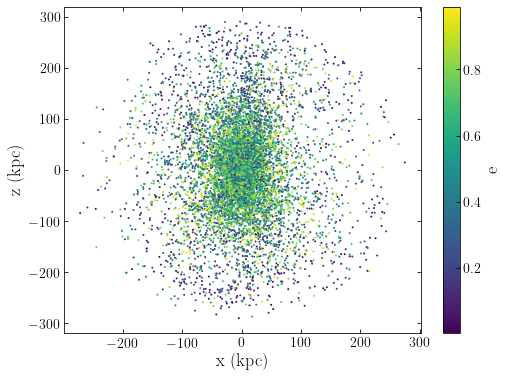

In [43]:
bovy_plot.bovy_print(fig_width=8,fig_height=6,axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)

plt.scatter(os[rindx].x(),os[rindx].z(),c=os[rindx].e(),s=1.)

#plt.xlim(0,100)
#plt.ylim(0,100)
plt.xlabel(r'$\rm x \ (kpc)$')
plt.ylabel(r'$\rm z \ (kpc)$')
cbar=plt.colorbar()
cbar.set_label(r'$\rm e$')
plt.savefig('via_lactea.pdf')
plt.show()
plt.close()

In [44]:
do_plot=False

ofile=open('submit.bat','w')
ofile_nfw=open('submit_nfw.bat','w')
ofile_legend=open('submit_legend.dat','w')
nsim=0

eps=np.array([])
mres=np.array([])

isvir=np.zeros(len(ps_sub),dtype=bool)

m_infall=np.array([])
ps_novir=np.array([])
rs_novir=np.array([])
mt_novir=np.array([])
rt_novir=np.array([])

for i in range(0,len(ps_sub)):
    #Want to simulate sub-halos with current apcoentres within 100 kpc and infall times < z=3
    #if mwD[i] <= 100. and ra[i] <= 100. and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.): # and gcgc[i]<=0.9*vesc100:
    if ra[i] <= 100. and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.) and vgc[i]<=0.9*vesc100:

        #print(i,ps_sub[i],rs_sub[i],x[indx][i],y[indx][i],z[indx][i])
        Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],debug=False)
        #Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],mhalo=mt_sub[i],debug=True)

        tsim=t_infallb[i]
        step=tsim/10.0
        
        if Nacc>0: 
            isvir[i]=True
            
            rad,rho,mass,command=make_halo(snfw,rt_sub[i],n=int(Nacc),nsim=nsim)
            m_infall=np.append(m_infall,snfw.mass(rt_sub[i]/8.))

            mres=np.append(mres,m_infall/float(Nacc))
            eps=np.append(eps,epsilon)
            
            o=os[i]
            print(i,o)

            ofile.write("%s\n" % command)  
            ofile.write('snapshift dmsub%s.nemo dmsub%s.nemo.shifted rshift=%f,%f,%f vshift=%f,%f,%f\n' % (nsim,nsim,o.x(),o.y(),o.z(),o.vx()/vcon,o.vy()/vcon,o.vz()/vcon))
            ofile.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'PowSphwCut+MiyamotoNagai+NFW\' accpars=\'0,1001.79126907,1.8,1.9#0,306770.418682,3.0,0.28#0,16.0,162.958241887\' > dmsub%i_shifted.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            ofile_nfw.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_nfw_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'NFW\' accpars=\'0,16.0,162.958241887\' > dmsub%i_shifted_nfw.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            nsim+=1

            ofile_legend.write('%f %f %f %f %f %f %f %f %f %f %f %f %f \n' % (rt_sub[i],ps_sub[i],rs_sub[i],rp[i],ecc[i],zmax[i],z_infallb[i],mt_sub[i],mt_sub0[i],rt_sub0[i],rgc[i],R_gc[i],z0[i]))   

            if do_plot:
                print(command)
                plt.plot(rad,mass)
                plt.plot([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]])
                plt.plot(rad,snfw.mass(rad/8,0.),'--')
                plt.show()
                plt.close()
            
            #break
        else:
            ps_novir=np.append(ps_novir,ps_sub[i])
            rs_novir=np.append(rs_novir,rs_sub[i])
            mt_novir=np.append(mt_novir,mt_sub[i])
            rt_novir=np.append(rt_novir,rt_sub[i])

ofile.close()
ofile_nfw.close()
ofile_legend.close()

MHALO, RHALO =  1674782.84805 0.132678097458
3846 <galpy.orbit.Orbits.Orbit object at 0x13e2e1090>
MHALO, RHALO =  7681244.0775 0.192891361244
3900 <galpy.orbit.Orbits.Orbit object at 0x14bd52d10>
MHALO, RHALO =  514120.429664 0.0678661598646
4044 <galpy.orbit.Orbits.Orbit object at 0x14bd582d0>
MHALO, RHALO =  4470625.70492 0.126036031037
4051 <galpy.orbit.Orbits.Orbit object at 0x13e2e1d90>
MHALO, RHALO =  170506.575872 0.0287220357166
4066 <galpy.orbit.Orbits.Orbit object at 0x14bd81fd0>
MHALO, RHALO =  1736905.12575 0.11922287268
4094 <galpy.orbit.Orbits.Orbit object at 0x14bd81e50>
MHALO, RHALO =  4095292.70443 0.155596555966
4113 <galpy.orbit.Orbits.Orbit object at 0x14bd81cd0>
MHALO, RHALO =  3294662.88957 0.158344199983
4190 <galpy.orbit.Orbits.Orbit object at 0x14bd81b10>
MHALO, RHALO =  411050793.517 0.720958299809
4218 <galpy.orbit.Orbits.Orbit object at 0x14bd81c90>
MHALO, RHALO =  1692030.02615 0.112850391662
4231 <galpy.orbit.Orbits.Orbit object at 0x14bd81c10>
MHALO, RHA

In [45]:
np.sum((rgc<100)*(ra <= 100.) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)),np.sum(isvir)

(2614, 2266)

In [46]:
len(ps_novir),np.amin(ps_novir),np.amax(ps_novir),len(rs_novir),np.amin(rs_novir),np.amax(rs_novir)

(190,
 0.75353317057516378,
 3.1335754265025817,
 190,
 0.023968870515772827,
 0.12798416705971571)

In [47]:
do_plot=False

ofile=open('submit_rp.bat','w')
ofile_nfw=open('submit_nfw_rp.bat','w')
ofile_legend=open('submit_legend_rp.dat','w')
nsim=0

isvir_rp=np.zeros(len(ps_sub),dtype=bool)

m_infall=np.array([])

for i in range(0,len(ps_sub)):
    #Want to simulate sub-halos with current apcoentres within 100 kpc and infall times < z=3
    if rgc[i] < 100. and ra[i] > 100. and rp[i]<=rvirial and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.) and (vgc[i]<=0.9*vesc100):
        #print(i,ps_sub[i],rs_sub[i],x[indx][i],y[indx][i],z[indx][i])
        Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],debug=False)
        #Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],mhalo=mt_sub[i],debug=True)
        
        tsim=t_infallb[i]
        step=tsim/10.0
        
        if Nacc>0: 
            isvir_rp[i]=True
            
            rad,rho,mass,command=make_halo(snfw,rt_sub[i],n=int(Nacc),nsim=nsim)
            m_infall=np.append(m_infall,snfw.mass(rt_sub[i]/8.))
            
            mres=np.append(mres,m_infall/float(Nacc))
            eps=np.append(eps,epsilon)

            o=os[i]
            print(i,o)

            ofile.write("%s\n" % command)  
            ofile.write('snapshift dmsub%s.nemo dmsub%s.nemo.shifted rshift=%f,%f,%f vshift=%f,%f,%f\n' % (nsim,nsim,o.x(),o.y(),o.z(),o.vx()/vcon,o.vy()/vcon,o.vz()/vcon))
            ofile.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'PowSphwCut+MiyamotoNagai+NFW\' accpars=\'0,1001.79126907,1.8,1.9#0,306770.418682,3.0,0.28#0,16.0,162.958241887\' > dmsub%i_shifted.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            ofile_nfw.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_nfw_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'NFW\' accpars=\'0,16.0,162.958241887\' > dmsub%i_shifted_nfw.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            nsim+=1

            ofile_legend.write('%f %f %f %f %f %f %f %f %f %f %f %f %f\n' % (rt_sub[i],ps_sub[i],rs_sub[i],rp[i],ecc[i],zmax[i],z_infallb[i],mt_sub[i],mt_sub0[i],rt_sub0[i],rgc[i],R_gc[i],z[i]))   

            if do_plot:
                print(command)
                plt.plot(rad,mass)
                plt.plot([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]])
                plt.plot(rad,snfw.mass(rad/8,0.),'--')
                plt.show()
                plt.close()
            
            #break
        else:
            ps_novir=np.append(ps_novir,ps_sub[i])
            rs_novir=np.append(rs_novir,rs_sub[i])
            mt_novir=np.append(mt_novir,mt_sub[i])
            rt_novir=np.append(rt_novir,rt_sub[i])
            
ofile.close()
ofile_nfw.close()
ofile_legend.close()

MHALO, RHALO =  14517317.9802 0.23605831923
3653 <galpy.orbit.Orbits.Orbit object at 0x13e2ca8d0>
MHALO, RHALO =  9942067.43616 0.38023425723
3711 <galpy.orbit.Orbits.Orbit object at 0x13e2d19d0>
MHALO, RHALO =  10471065.2576 0.392145492884
3836 <galpy.orbit.Orbits.Orbit object at 0x13daecbd0>
MHALO, RHALO =  13803985.2923 0.247927937926
3839 <galpy.orbit.Orbits.Orbit object at 0x14c1b1b10>
MHALO, RHALO =  865404.62135 0.0779282153724
3856 <galpy.orbit.Orbits.Orbit object at 0x13e2e15d0>
MHALO, RHALO =  652320.19833 0.0711908923601
3868 <galpy.orbit.Orbits.Orbit object at 0x14c1b44d0>
MHALO, RHALO =  2929039.78379 0.150576626067
3882 <galpy.orbit.Orbits.Orbit object at 0x14c1b1b10>
MHALO, RHALO =  5678196.4567 0.231304275449
3887 <galpy.orbit.Orbits.Orbit object at 0x13e2ca8d0>
MHALO, RHALO =  5535197.86675 0.31974400947
3898 <galpy.orbit.Orbits.Orbit object at 0x13e2e15d0>
MHALO, RHALO =  744151.415152 0.116607478105
3903 <galpy.orbit.Orbits.Orbit object at 0x13daecbd0>
MHALO, RHALO =

In [48]:
np.sum(isvir_rp)

1525

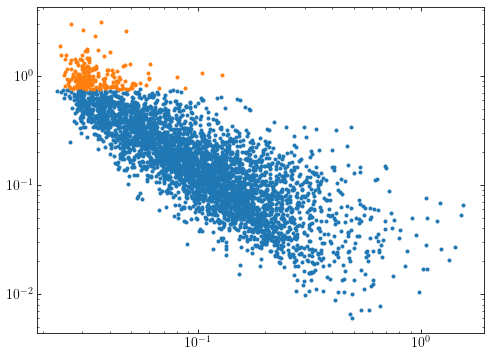

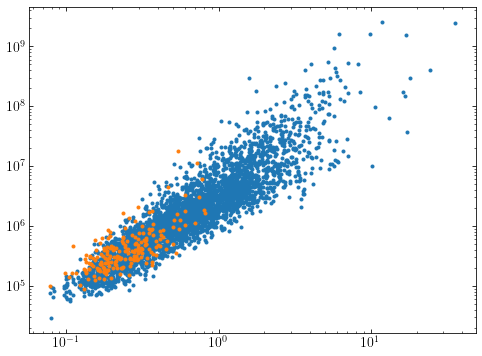

In [49]:
indx=np.logical_or(isvir,isvir_rp)
#plt.loglog(rs_sub[isvir],ps_sub[isvir],'.')
#plt.loglog(rs_sub[isvir_rp],ps_sub[isvir_rp],'.')

plt.loglog(rs_sub[indx],ps_sub[indx],'.')
plt.loglog(rs_novir,ps_novir,'.')
plt.show()
plt.close()

#plt.loglog(rt_sub[isvir],mt_sub[isvir],'.')
#plt.loglog(rt_sub[isvir_rp],mt_sub[isvir_rp],'.')
plt.loglog(rt_sub[indx],mt_sub[indx],'.')
plt.loglog(rt_novir,mt_novir,'.')
plt.show()
plt.close()



In [50]:
print(rs_novir[0],ps_novir[0])

0.0294755800941 1.02362259836


In [51]:
vindx=vmax_sub>5.0
print(np.sum(vindx),len(vindx),len(mt_sub))
print(np.amin(mt_sub[vindx]),np.amax(mt_sub[vindx]),np.log10(np.amin(mt_sub[vindx])),np.log10(np.amax(mt_sub[vindx])))

vindx=vmax_sub>4.5
print(np.sum(vindx),len(vindx),len(mt_sub))
print(np.amin(mt_sub[vindx]),np.amax(mt_sub[vindx]),np.log10(np.amin(mt_sub[vindx])),np.log10(np.amax(mt_sub[vindx])))


2875 9180 9180
756166.0 9063860000.0 5.87861714599 9.95731318881
3848 9180 9180
458070.0 9063860000.0 5.66093184982 9.95731318881


In [52]:
Nacc,epsilon,snfw=check_subhalo(ps_novir[0],rs_novir[0],debug=False)
print(Nacc)

MHALO, RHALO =  329410.025108 0.0294755800941
HALO NOT VIRIALISED 988211.7688026185 329410.025108 0.0294755800941 2576910.47106
-1


In [53]:
np.amin(ps_novir),np.amax(ps_novir)

(0.75353317057516378, 3.1335754265025817)

In [54]:
np.amin(eps),np.mean(eps)*1000.0,np.amax(eps),np.amin(mres),np.mean(mres),np.amax(mres)

(1.693567881014262e-05,
 0.19100574074950444,
 0.0022587571556807462,
 0.037081411216090224,
 13.878064713748945,
 3998.2498028205628)

In [55]:
np.sum((rgc<100)*(ra > 100.) * (rp<=rvirial) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)),np.sum(isvir_rp)

(1923, 1525)

In [56]:
batch1=(ra <= 100.) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.) * (vgc<=0.9*vesc100)
print(np.sum(batch1),np.sum(batch1)-np.sum(isvir),np.sum(batch1*isvir))
batch2= (rgc < 100.) * (ra > 100.) * (rp<=rvirial) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.) * (vgc<=0.9*vesc100)
print(np.sum(batch2),np.sum(batch2)-np.sum(isvir_rp),np.sum(batch2*isvir_rp))
print(np.sum(isvir)+np.sum(batch2))

fullbatch=(rgc < 100.)*(rp<=rvirial) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.) * (vgc<=0.9*vesc100)
fullbatch_isvir=np.logical_or(batch1*isvir,batch2*isvir_rp)

print(np.sum(fullbatch),np.sum(fullbatch_isvir))

2456 190 2266
1540 15 1525
3806
3996 3791


In [57]:
#Check infall mass distribution of ones flagging error
#likely too low mass and/or too compact


In [58]:
do_plot=False

ofile=open('submit_rv.bat','w')
ofile_nfw=open('submit_nfw_rv.bat','w')
ofile_legend=open('submit_legend_rv.dat','w')
nsim=0

isvir_rv=np.zeros(len(ps_sub),dtype=bool)

rvtest=[]

m_infall=np.array([])

for i in range(0,len(ps_sub)):
    #Want to simulate sub-halos with current apcoentres within 100 kpc and infall times < z=3
    if rgc[i]<100 and rp[i]<=rvirial and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.) and not fullbatch_isvir[i]:
        #print(i,ps_sub[i],rs_sub[i],x[indx][i],y[indx][i],z[indx][i])
        Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],debug=False,wrtcrit=True)
        #Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],mhalo=mt_sub[i],debug=True)

        
        tsim=t_infallb[i]
        step=tsim/10.0
        
        if Nacc>0: 
            isvir_rv[i]=True
            
            rvtest.append(snfw.rvir())
            
            rad,rho,mass,command=make_halo(snfw,rt_sub[i],n=int(Nacc),nsim=nsim)
            m_infall=np.append(m_infall,snfw.mass(rt_sub[i]/8.))

            o=os[i]
            print(i,o)

            ofile.write("%s\n" % command)  
            ofile.write('snapshift dmsub%s.nemo dmsub%s.nemo.shifted rshift=%f,%f,%f vshift=%f,%f,%f\n' % (nsim,nsim,o.x(),o.y(),o.z(),o.vx()/vcon,o.vy()/vcon,o.vz()/vcon))
            ofile.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'PowSphwCut+MiyamotoNagai+NFW\' accpars=\'0,1001.79126907,1.8,1.9#0,306770.418682,3.0,0.28#0,16.0,162.958241887\' > dmsub%i_shifted.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            ofile_nfw.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_nfw_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'NFW\' accpars=\'0,16.0,162.958241887\' > dmsub%i_shifted_nfw.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            nsim+=1

            ofile_legend.write('%f %f %f %f %f %f %f %f %f %f %f %f %f\n' % (rt_sub[i],ps_sub[i],rs_sub[i],rp[i],ecc[i],zmax[i],z_infallb[i],mt_sub[i],mt_sub0[i],rt_sub0[i],rgc[i],R_gc[i],z[i]))   

            if do_plot:
                print(command)
                plt.plot(rad,mass)
                plt.plot([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]])
                plt.plot(rad,snfw.mass(rad/8,0.),'--')
                plt.show()
                plt.close()
            
            #break
            
ofile.close()
ofile_nfw.close()
ofile_legend.close()

MHALO, RHALO =  209474.482745 0.0276720861194
HALO NOT VIRIALISED 988211.7688026185 209474.482745 0.0276720861194 1651900.09258
MHALO, RHALO =  329410.025108 0.0294755800941
HALO NOT VIRIALISED 988211.7688026185 329410.025108 0.0294755800941 2576910.47106
MHALO, RHALO =  11279444.2385 0.314548825939
4395 <galpy.orbit.Orbits.Orbit object at 0x143874410>
MHALO, RHALO =  1439922.84117 0.0509530283273
HALO NOT VIRIALISED 988211.7688026185 1439922.84117 0.0509530283273 10476414.7692
MHALO, RHALO =  221519.020736 0.0283496564289
HALO NOT VIRIALISED 988211.7688026185 221519.020736 0.0283496564289 1741525.21207
MHALO, RHALO =  381382.913025 0.0317492069658
HALO NOT VIRIALISED 988211.7688026185 381382.913025 0.0317492069658 2955154.02634
MHALO, RHALO =  308081.611934 0.029807544692
HALO NOT VIRIALISED 988211.7688026185 308081.611934 0.029807544692 2406613.13831
MHALO, RHALO =  670548.344438 0.0381535018358
HALO NOT VIRIALISED 988211.7688026185 670548.344438 0.0381535018358 5072588.64548
MHALO, 

In [59]:
np.sum(isvir_rv)

533

In [60]:
allbatch=(rp<=100.) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)
final_batch=allbatch*np.invert(isvir_rv)*np.invert(batch1)*np.invert(batch2)


print(np.sum(allbatch),np.sum(final_batch),np.sum(batch1),np.sum(batch2),np.sum(isvir_rv),np.sum(final_batch)+np.sum(batch1)+np.sum(batch2)+np.sum(isvir_rv))

6823 2294 2456 1540 533 6823


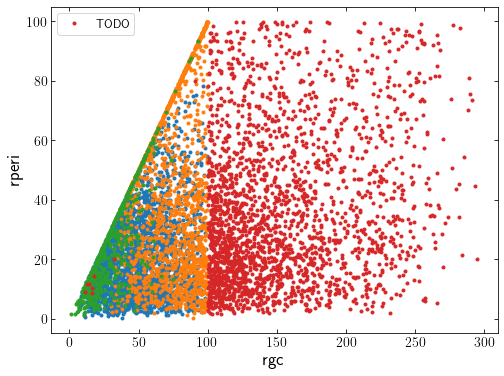

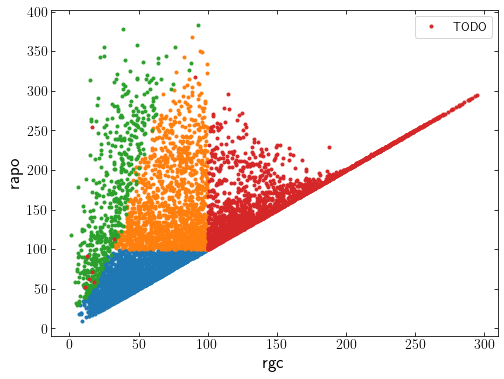

In [61]:
plt.plot(rgc[batch1],rp[batch1],'.')
plt.plot(rgc[batch2],rp[batch2],'.')
plt.plot(rgc[isvir_rv],rp[isvir_rv],'.')
plt.plot(rgc[final_batch],rp[final_batch],'.',label='TODO')
plt.legend()
plt.xlabel('rgc')
plt.ylabel('rperi')

plt.show()
plt.close()

plt.plot(rgc[batch1],ra[batch1],'.')
plt.plot(rgc[batch2],ra[batch2],'.')
plt.plot(rgc[isvir_rv],ra[isvir_rv],'.')
plt.plot(rgc[final_batch],ra[final_batch],'.',label='TODO')
plt.legend()
plt.xlabel('rgc')
plt.ylabel('rapo')

plt.show()
plt.close()

No handles with labels found to put in legend.


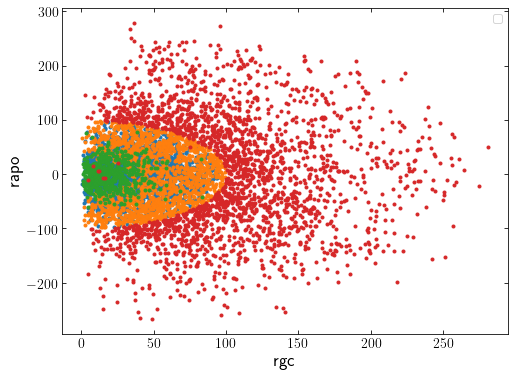

In [62]:
plt.plot(R_gc[batch1],z0[batch1],'.')
plt.plot(R_gc[batch2],z0[batch2],'.')
plt.plot(R_gc[isvir_rv],z0[isvir_rv],'.')
plt.plot(R_gc[final_batch],z0[final_batch],'.')
plt.legend()
plt.xlabel('rgc')
plt.ylabel('rapo')

plt.show()
plt.close()

In [63]:
np.sum(final_batch)

2294

In [64]:
do_plot=False

ofile=open('submit_final.bat','w')
ofile_nfw=open('submit_nfw_final.bat','w')
ofile_legend=open('submit_legend_final.dat','w')
nsim=0

isvir_final=np.zeros(len(ps_sub),dtype=bool)

rvtest=[]

m_infall=np.array([])

for i in range(0,len(ps_sub)):
    #Want to simulate sub-halos with current apcoentres within 100 kpc and infall times < z=3
    if final_batch[i]:
        #print(i,ps_sub[i],rs_sub[i],x[indx][i],y[indx][i],z[indx][i])
        Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],debug=False,wrtcrit=True)
        #Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],mhalo=mt_sub[i],debug=True)

        
        tsim=t_infallb[i]
        step=tsim/10.0
        
        if Nacc>0: 
            isvir_final[i]=True
            
            rvtest.append(snfw.rvir())
            
            rad,rho,mass,command=make_halo(snfw,rt_sub[i],n=int(Nacc),nsim=nsim)
            m_infall=np.append(m_infall,snfw.mass(rt_sub[i]/8.))

            o=os[i]
            print(i,o)

            ofile.write("%s\n" % command)  
            ofile.write('snapshift dmsub%s.nemo dmsub%s.nemo.shifted rshift=%f,%f,%f vshift=%f,%f,%f\n' % (nsim,nsim,o.x(),o.y(),o.z(),o.vx()/vcon,o.vy()/vcon,o.vz()/vcon))
            ofile.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'PowSphwCut+MiyamotoNagai+NFW\' accpars=\'0,1001.79126907,1.8,1.9#0,306770.418682,3.0,0.28#0,16.0,162.958241887\' > dmsub%i_shifted.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            ofile_nfw.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_nfw_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'NFW\' accpars=\'0,16.0,162.958241887\' > dmsub%i_shifted_nfw.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            nsim+=1

            ofile_legend.write('%f %f %f %f %f %f %f %f %f %f %f %f %f\n' % (rt_sub[i],ps_sub[i],rs_sub[i],rp[i],ecc[i],zmax[i],z_infallb[i],mt_sub[i],mt_sub0[i],rt_sub0[i],rgc[i],R_gc[i],z[i]))   

            if do_plot:
                print(command)
                plt.plot(rad,mass)
                plt.plot([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]])
                plt.plot(rad,snfw.mass(rad/8,0.),'--')
                plt.show()
                plt.close()
            
            #break
            
ofile.close()
ofile_nfw.close()
ofile_legend.close()

MHALO, RHALO =  9241151.31619 0.406801598091
1 <galpy.orbit.Orbits.Orbit object at 0x14388aa50>
MHALO, RHALO =  2610970.92302 0.143009738368
25 <galpy.orbit.Orbits.Orbit object at 0x1439e08d0>
MHALO, RHALO =  5822175.73399 0.26711058088
32 <galpy.orbit.Orbits.Orbit object at 0x1439d9110>
MHALO, RHALO =  6718086.07919 0.145853101388
35 <galpy.orbit.Orbits.Orbit object at 0x13d45f950>
MHALO, RHALO =  4660086.14538 0.190715719187
48 <galpy.orbit.Orbits.Orbit object at 0x14388a750>
MHALO, RHALO =  9502044.54067 0.263438115584
52 <galpy.orbit.Orbits.Orbit object at 0x143918ad0>
MHALO, RHALO =  12564803.0491 0.364534028799
60 <galpy.orbit.Orbits.Orbit object at 0x14bd28e50>
MHALO, RHALO =  9809502.46822 0.314149765558
83 <galpy.orbit.Orbits.Orbit object at 0x143801410>
MHALO, RHALO =  12156492.3498 0.259590396656
84 <galpy.orbit.Orbits.Orbit object at 0x14388a950>
MHALO, RHALO =  7794426.68042 0.223760045871
94 <galpy.orbit.Orbits.Orbit object at 0x13e2e0490>
MHALO, RHALO =  3763341.49391 0.

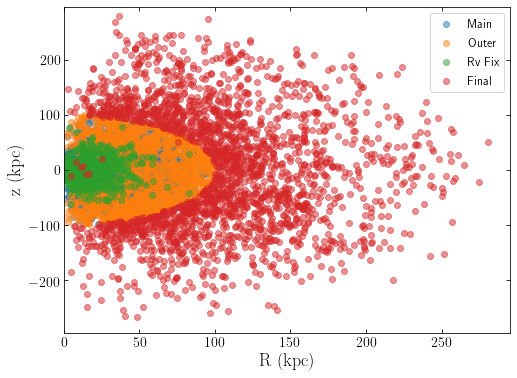

In [74]:
plt.scatter(R_gc[batch1],z0[batch1],label='Main',alpha=0.5)

plt.scatter(R_gc[batch2],z0[batch2],label='Outer',alpha=0.5)
plt.scatter(R_gc[isvir_rv],z0[isvir_rv],label='Rv Fix',alpha=0.5)
plt.scatter(R_gc[final_batch],z0[final_batch],label='Final',alpha=0.5)

plt.legend()

plt.xlabel(r'$\rm R \ (kpc)$')
plt.ylabel(r'$\rm z \ (kpc)$')
plt.xlim(0,rv)
plt.ylim(-rv,rv)
plt.show()
plt.close()

In [77]:
np.sum(batch1*final_batch)

0

In [65]:
indx3=(rgc>100)*(ra > 100.) * (rp<=rvirial) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)
np.sum((rgc>100)*(ra > 100.) * (rp<=rvirial) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)),np.sum(isvir_rv)

(4104, 533)

In [66]:
np.sum(indx1),np.sum(isvir),np.sum(indx2),np.sum(isvir_rp),np.sum(indx3),np.sum(isvir_rv)

(2614, 2266, 6027, 1525, 4104, 533)

In [67]:
do_plot=False

ofile=open('submit_lowres.bat','w')
ofile_nfw=open('submit_nfw_lowres.bat','w')
ofile_legend=open('submit_legend_lowres.dat','w')
nsim=0

eps=np.array([])
mres=np.array([])

isvir_lowres=np.zeros(len(ps_sub),dtype=bool)

m_infall=np.array([])

for i in range(0,len(ps_sub)):
    #Want to simulate sub-halos with current apcoentres within 100 kpc and infall times < z=3
    #if mwD[i] <= 100. and ra[i] <= 100. and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.): # and gcgc[i]<=0.9*vesc100:
    if ra[i] <= 100. and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.) and vgc[i]<=0.9*vesc100:

        #print(i,ps_sub[i],rs_sub[i],x[indx][i],y[indx][i],z[indx][i])
        Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],debug=False,mdm=3.0e4)
        #Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],mhalo=mt_sub[i],debug=True)

        tsim=t_infallb[i]
        step=tsim/10.0
        
        if Nacc>0: 
            isvir_lowres[i]=True
            
            rad,rho,mass,command=make_halo(snfw,rt_sub[i],n=int(Nacc),nsim=nsim,lowres=True)
            m_infall=np.append(m_infall,snfw.mass(rt_sub[i]/8.))

            mres=np.append(mres,m_infall/float(Nacc))
            eps=np.append(eps,epsilon)
            
            o=os[i]
            print(i,o)

            ofile.write("%s\n" % command)  
            ofile.write('snapshift dmsub%s.nemo dmsub%s.nemo.shifted rshift=%f,%f,%f vshift=%f,%f,%f\n' % (nsim,nsim,o.x(),o.y(),o.z(),o.vx()/vcon,o.vy()/vcon,o.vz()/vcon))
            ofile.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'PowSphwCut+MiyamotoNagai+NFW\' accpars=\'0,1001.79126907,1.8,1.9#0,306770.418682,3.0,0.28#0,16.0,162.958241887\' > dmsub%i_shifted.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            ofile_nfw.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_nfw_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'NFW\' accpars=\'0,16.0,162.958241887\' > dmsub%i_shifted_nfw.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            nsim+=1

            ofile_legend.write('%f %f %f %f %f %f %f %f %f %f %f %f %f \n' % (rt_sub[i],ps_sub[i],rs_sub[i],rp[i],ecc[i],zmax[i],z_infallb[i],mt_sub[i],mt_sub0[i],rt_sub0[i],rgc[i],R_gc[i],z0[i]))   

            if do_plot:
                print(command)
                plt.plot(rad,mass)
                plt.plot([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]])
                plt.plot(rad,snfw.mass(rad/8,0.),'--')
                plt.show()
                plt.close()
            
            #break
            
ofile.close()
ofile_nfw.close()
ofile_legend.close()

MHALO, RHALO =  1674782.84805 0.132678097458
3846 <galpy.orbit.Orbits.Orbit object at 0x13a313750>
MHALO, RHALO =  7681244.0775 0.192891361244
3900 <galpy.orbit.Orbits.Orbit object at 0x13f85cfd0>
MHALO, RHALO =  514120.429664 0.0678661598646
4044 <galpy.orbit.Orbits.Orbit object at 0x139376450>
MHALO, RHALO =  4470625.70492 0.126036031037
4051 <galpy.orbit.Orbits.Orbit object at 0x13a20d490>
MHALO, RHALO =  170506.575872 0.0287220357166
4066 <galpy.orbit.Orbits.Orbit object at 0x139376810>
MHALO, RHALO =  1736905.12575 0.11922287268
4094 <galpy.orbit.Orbits.Orbit object at 0x13953d7d0>
MHALO, RHALO =  4095292.70443 0.155596555966
4113 <galpy.orbit.Orbits.Orbit object at 0x13956dd10>
MHALO, RHALO =  3294662.88957 0.158344199983
4190 <galpy.orbit.Orbits.Orbit object at 0x148204610>
MHALO, RHALO =  411050793.517 0.720958299809
4218 <galpy.orbit.Orbits.Orbit object at 0x1393766d0>
MHALO, RHALO =  1692030.02615 0.112850391662
4231 <galpy.orbit.Orbits.Orbit object at 0x1393c1390>
MHALO, RHA

In [68]:
do_plot=False

ofile=open('submit_lowres2.bat','w')
ofile_nfw=open('submit_nfw_lowres2.bat','w')
ofile_legend=open('submit_legend_lowres2.dat','w')
nsim=0

eps2=np.array([])
mres2=np.array([])

isvir_lowres2=np.zeros(len(ps_sub),dtype=bool)

m_infall2=np.array([])

for i in range(0,len(ps_sub)):
    #Want to simulate sub-halos with current apcoentres within 100 kpc and infall times < z=3
    #if mwD[i] <= 100. and ra[i] <= 100. and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.): # and gcgc[i]<=0.9*vesc100:
    if ra[i] <= 100. and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.) and vgc[i]<=0.9*vesc100:

        #print(i,ps_sub[i],rs_sub[i],x[indx][i],y[indx][i],z[indx][i])
        Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],debug=False,mdm=4.1e3)
        #Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],mhalo=mt_sub[i],debug=True)

        tsim=t_infallb[i]
        step=tsim/10.0
        
        if Nacc>0: 
            isvir_lowres2[i]=True
            
            rad,rho,mass,command=make_halo(snfw,rt_sub[i],n=int(Nacc),nsim=nsim,lowres=True)
            m_infall2=np.append(m_infall,snfw.mass(rt_sub[i]/8.))

            mres2=np.append(mres,m_infall/float(Nacc))
            eps2=np.append(eps,epsilon)
            
            o=os[i]
            print(i,o)

            ofile.write("%s\n" % command)  
            ofile.write('snapshift dmsub%s.nemo dmsub%s.nemo.shifted rshift=%f,%f,%f vshift=%f,%f,%f\n' % (nsim,nsim,o.x(),o.y(),o.z(),o.vx()/vcon,o.vy()/vcon,o.vz()/vcon))
            ofile.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'PowSphwCut+MiyamotoNagai+NFW\' accpars=\'0,1001.79126907,1.8,1.9#0,306770.418682,3.0,0.28#0,16.0,162.958241887\' > dmsub%i_shifted.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            ofile_nfw.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_nfw_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'NFW\' accpars=\'0,16.0,162.958241887\' > dmsub%i_shifted_nfw.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            nsim+=1

            ofile_legend.write('%f %f %f %f %f %f %f %f %f %f %f %f %f \n' % (rt_sub[i],ps_sub[i],rs_sub[i],rp[i],ecc[i],zmax[i],z_infallb[i],mt_sub[i],mt_sub0[i],rt_sub0[i],rgc[i],R_gc[i],z0[i]))   

            if do_plot:
                print(command)
                plt.plot(rad,mass)
                plt.plot([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]])
                plt.plot(rad,snfw.mass(rad/8,0.),'--')
                plt.show()
                plt.close()
            
            #break
            
ofile.close()
ofile_nfw.close()
ofile_legend.close()

MHALO, RHALO =  1674782.84805 0.132678097458
3846 <galpy.orbit.Orbits.Orbit object at 0x13f81ed50>
MHALO, RHALO =  7681244.0775 0.192891361244
3900 <galpy.orbit.Orbits.Orbit object at 0x1396cc090>
MHALO, RHALO =  514120.429664 0.0678661598646
4044 <galpy.orbit.Orbits.Orbit object at 0x13f7ac950>
MHALO, RHALO =  4470625.70492 0.126036031037
4051 <galpy.orbit.Orbits.Orbit object at 0x1393c14d0>
MHALO, RHALO =  170506.575872 0.0287220357166
4066 <galpy.orbit.Orbits.Orbit object at 0x13953ded0>
MHALO, RHALO =  1736905.12575 0.11922287268
4094 <galpy.orbit.Orbits.Orbit object at 0x13a313110>
MHALO, RHALO =  4095292.70443 0.155596555966
4113 <galpy.orbit.Orbits.Orbit object at 0x1396cc090>
MHALO, RHALO =  3294662.88957 0.158344199983
4190 <galpy.orbit.Orbits.Orbit object at 0x13f6d9310>
MHALO, RHALO =  411050793.517 0.720958299809
4218 <galpy.orbit.Orbits.Orbit object at 0x13f7ac950>
MHALO, RHALO =  1692030.02615 0.112850391662
4231 <galpy.orbit.Orbits.Orbit object at 0x13a313110>
MHALO, RHA

In [69]:
np.sum((rgc<100)*(ra <= 100.) * (z_infallb > 0.) * (z_infallb < 3.) * (rs_sub > 0.)),np.sum(isvir_lowres)

(2614, 2266)

In [70]:
non_indx=np.invert(np.logical_or(indx1,indx2))
print(np.sum(non_indx*(rgc<rvirial)))



539


In [71]:
do_plot=False

ofile=open('submit_norv.bat','w')
ofile_nfw=open('submit_nfw_norv.bat','w')
ofile_legend=open('submit_legend_norv.dat','w')
nsim=0

eps_norv=np.array([])
m_norv=np.array([])

isvir_norv=np.zeros(len(ps_sub),dtype=bool)

m_infall_norv=np.array([])

for i in range(0,len(ps_sub)):
    #Want to simulate sub-halos with current apcoentres within 100 kpc and infall times < z=3
    #if mwD[i] <= 100. and ra[i] <= 100. and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.): # and gcgc[i]<=0.9*vesc100:
    if rp[i]<=rvirial and (z_infallb[i] > 0.) and (z_infallb[i] < 3.) and (rs_sub[i] > 0.) and (vgc[i]<=0.9*vesc100):

        #print(i,ps_sub[i],rs_sub[i],x[indx][i],y[indx][i],z[indx][i])
        Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],debug=False,mdm=3.0e4)
        #Nacc,epsilon,snfw=check_subhalo(ps_sub[i],rs_sub[i],mhalo=mt_sub[i],debug=True)

        tsim=t_infallb[i]
        step=tsim/10.0
        
        if Nacc>0: 
            isvir_norv[i]=True
            
            rad,rho,mass,command=make_halo(snfw,rt_sub[i],n=int(Nacc),nsim=nsim)
            m_infall_norv=np.append(m_infall_norv,snfw.mass(rt_sub[i]/8.))

            m_norv=np.append(m_norv,m_infall/float(Nacc))
            eps_norv=np.append(eps_norv,epsilon)
            
            o=os[i]
            print(i,o)

            ofile.write("%s\n" % command)  
            ofile.write('snapshift dmsub%s.nemo dmsub%s.nemo.shifted rshift=%f,%f,%f vshift=%f,%f,%f\n' % (nsim,nsim,o.x(),o.y(),o.z(),o.vx()/vcon,o.vy()/vcon,o.vz()/vcon))
            ofile.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'PowSphwCut+MiyamotoNagai+NFW\' accpars=\'0,1001.79126907,1.8,1.9#0,306770.418682,3.0,0.28#0,16.0,162.958241887\' > dmsub%i_shifted.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            ofile_nfw.write('gyrfalcON in=dmsub%s.nemo.shifted out=dmsub%s_nfw_evol.nemo tstop=%f eps=%f kernel=2 step=%f kmax=8 Nlev=1 fac=0.01 accname=\'NFW\' accpars=\'0,16.0,162.958241887\' > dmsub%i_shifted_nfw.nemo.out 2>&1 \n' % (nsim,nsim,tsim,epsilon,step,nsim))

            nsim+=1

            ofile_legend.write('%f %f %f %f %f %f %f %f %f %f %f %f %f \n' % (rt_sub[i],ps_sub[i],rs_sub[i],rp[i],ecc[i],zmax[i],z_infallb[i],mt_sub[i],mt_sub0[i],rt_sub0[i],rgc[i],R_gc[i],z0[i]))   

            if do_plot:
                print(command)
                plt.plot(rad,mass)
                plt.plot([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]])
                plt.plot(rad,snfw.mass(rad/8,0.),'--')
                plt.show()
                plt.close()
            
            #break
            
ofile.close()
ofile_nfw.close()
ofile_legend.close()

MHALO, RHALO =  2737775.6923 0.200576163656
0 <galpy.orbit.Orbits.Orbit object at 0x13a20d7d0>
MHALO, RHALO =  9241151.31619 0.406801598091
1 <galpy.orbit.Orbits.Orbit object at 0x13f71e850>
MHALO, RHALO =  400050.080559 0.0619856837666
2 <galpy.orbit.Orbits.Orbit object at 0x13f71eed0>
MHALO, RHALO =  7717271.46259 0.297967705241
3 <galpy.orbit.Orbits.Orbit object at 0x13a1ec510>
MHALO, RHALO =  3495673.61439 0.228047054907
5 <galpy.orbit.Orbits.Orbit object at 0x13faaca10>
MHALO, RHALO =  238301.022998 0.0330637479307
6 <galpy.orbit.Orbits.Orbit object at 0x13f71eed0>
MHALO, RHALO =  3125238.91504 0.189599922315
7 <galpy.orbit.Orbits.Orbit object at 0x13a1ec510>
MHALO, RHALO =  3115629.0328 0.152679207243
8 <galpy.orbit.Orbits.Orbit object at 0x13f71e850>
MHALO, RHALO =  12785756.2665 0.291409797557
9 <galpy.orbit.Orbits.Orbit object at 0x13928eb90>
MHALO, RHALO =  2740309.79479 0.125766908045
10 <galpy.orbit.Orbits.Orbit object at 0x13a20d7d0>
MHALO, RHALO =  1165197.60043 0.0913672

KeyboardInterrupt: 

In [ ]:
rpeindx=(ra <= 100.) * (z_infallb > 0.) * (z_infallb < 3.)
vindx=rpeindx*isvir

print(len(m_infall),np.sum(vindx))

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)


plt.loglog(mt_sub[vindx],m_infall,'.')
plt.loglog([1.0e4,1.0e10],[1.0e4,1.0e10],'--')
plt.xlabel('M @ Infall (VL2)')
plt.ylabel('M @ Infall (NFW)')
plt.savefig('minfall_compare.png')
plt.show()
plt.close()

In [ ]:
dmcluster=npy.load_cluster(ctype='gyrfalcon',filename='dmsub0.nemo.dat')

In [ ]:
plt.semilogy(dmcluster.r[dmcluster.rorder],np.cumsum(dmcluster.m[dmcluster.rorder]),label='mkhalo')
plt.semilogy(rad,mass,label='menc')
plt.semilogy([rt_sub[i],rt_sub[i]],[0.,mt_sub[i]],label='halo')
plt.semilogy(rad,snfw.mass(rad/8,0.),'--',label='Pot')
plt.xlim(0,1)
plt.legend()
plt.show()
plt.close()

print(rs_sub[i],ps_sub[i],rt_sub[i],mt_sub[i])

In [ ]:
print(ps_sub[188],rs_sub[188])
Nacc,epsilon,snfw=check_subhalo(ps_sub[188],rs_sub[188],debug=True)


rpeindx=(ra <= 100.) * (z_infallb[i] > 0.) * (z_infallb[i] < 3.)
vindx=rpeindx*isvir

plt.plot(ecc[rpeindx],rp[rpeindx],'.',label='All')
plt.plot(ecc[vindx],rp[vindx],'.',label='Virialised')

plt.legend()

plt.xlabel('e')
plt.ylabel('rp')
plt.show()
plt.close()

plt.plot(ecc[rpeindx],zmax[rpeindx],'.')
plt.plot(ecc[vindx],zmax[vindx],'.')

plt.xlabel('e')
plt.ylabel('zmax')
plt.show()
plt.close()


- It does not seem like the density profile of central halo is given at other redshifts, except in Via Lactea 2
    - Or we assume something given Mtidal, rvmax, and vmax?

In [ ]:

#What about later redshifts??
stepToTimeVL2=np.loadtxt('stepToTimeVL2.txt')
zshift=np.flip(stepToTimeVL2[:,2],axis=0)
tshift=np.flip(stepToTimeVL2[:,3],axis=0)

progRtidal=np.loadtxt('progRtidal.txt')
rtz0=progRtidal[:,0] #kpc
rtz=progRtidal[:,-10] #kpc

progMtidal=np.loadtxt('progMtidal.txt')
mz0=progMtidal[:,0] #Msun
mz=progMtidal[:,-10] #Msun

progGCdistance=np.loadtxt('progGCdistance.txt')
dz0=progGCdistance[:,0] #kpc
dz=progGCdistance[:,-10] #kpc

progVmax=np.loadtxt('progVmax.txt')
vmaxz0=progVmax[:,0] #kpc
vmaxz=progVmax[:,-10] #kpc

progRvmax=np.loadtxt('progRvmax.txt')
rvmaxz0=progRvmax[:,0] #kpc
rvmaxz=progRvmax[:,-10] #kpc



In [ ]:
np.sum(rpeindx)

In [ ]:
mwindx=np.argwhere(dz0==0.)
print(mwindx)
rtmw=progRtidal[mwindx,:][0][0]
mmw=progMtidal[mwindx,:][0][0]
dmw=progGCdistance[mwindx,:][0][0]
vmw=progVmax[mwindx,:][0][0]
rvmw=progRvmax[mwindx,:][0][0]

In [ ]:
npy.nplot(zshift,mmw,'-',alpha=1.,logy=False,xlabel='z',ylabel='M (Msun)')
npy.nplot(zshift,mmw,'o',alpha=1.,logy=False,overplot=True)

plt.plot(zshift,nfw.mass(rtmw/r0,0.0,ro=r0,vo=v0),label='NFW2014')
plt.legend()
plt.show()
plt.close()

npy.nplot(zshift,rtmw,'-',alpha=1.,logy=False,xlabel='z',ylabel='rt (kpc)')
npy.nplot(zshift,rtmw,'o',alpha=1.,logy=False,overplot=True)
plt.show()
plt.close()

npy.nplot(zshift,vmw,'-',alpha=1.,logy=False,xlabel='z',ylabel='Vmax (km/s)')
npy.nplot(zshift,vmw,'o',alpha=1.,logy=False,overplot=True)
plt.plot(zshift,nfw.vcirc(rvmw/r0,0.0,ro=r0,vo=v0),label='NFW2014')
plt.legend()
plt.show()
plt.close()

npy.nplot(zshift,rvmw,'-',alpha=1.,logy=False,xlabel='z',ylabel='R Vmax (kpc)')
npy.nplot(zshift,rvmw,'o',alpha=1.,logy=False,overplot=True)
plt.show()
plt.close()

In [ ]:
plt.plot(dz0,rtz0,'.')
plt.ylim(0,100)
plt.xlabel('Distance (kpc)')
plt.ylabel(r'$r_t$ (kpc)')
plt.title(zshift[0])

plt.show()
plt.close()

plt.plot(dz,rtz,'.')
#plt.ylim(0,100)
plt.title(zshift[-10])

plt.xlabel('Distance (kpc)')
plt.ylabel(r'$r_t$ (kpc)')

plt.show()
plt.close()

In [ ]:
plt.semilogx(mz0,rtz0,'.')
plt.ylim(0,100)
plt.xlabel('Log M (Msun)')
plt.ylabel(r'$r_t$ (kpc)')
plt.show()
plt.close()

In [ ]:
plt.semilogx(mz0,dz0,'.')
plt.xlabel('Log M (Msun)')
plt.ylabel(r'Distance (kpc)')
plt.show()
plt.close()

In [ ]:
indx=(dz0<100.) & (rtz0 < 10)

plt.plot(dz0[indx],rtz0[indx],'.')
plt.ylim(0,10)
plt.xlabel('Distance (kpc)')
plt.ylabel(r'$r_t$ (kpc)')
plt.show()
plt.close()

plt.semilogx(mz0[indx],rtz0[indx],'.')
plt.ylim(0,10)
plt.xlabel('Log M (Msun) (D < 100 kpc)' )
plt.ylabel(r'$r_t$ (kpc) (D < 100 kpc)')
plt.show()
plt.close()

plt.semilogx(mz0[indx],dz0[indx],'.')
plt.ylim(0,100)
plt.xlabel('Log M (Msun) (D < 100 kpc)' )
plt.ylabel('Distance (kpc)')
plt.show()
plt.close()

In [ ]:
plt.hist(rtz0[indx],bins=50)
plt.xlabel(r'$r_t$ (kpc) (D < 100 kpc)')
plt.show()
plt.close()

In [ ]:
ascale=1.05*np.sqrt(mz0/1.0e8)

In [ ]:
plt.plot(ascale[indx],rtz0[indx],'.')
plt.plot(ascale[indx],ascale[indx],'--')
plt.xlabel('a (kpc) (D < 100 kpc)')
plt.ylabel(r'$r_t$ (kpc) (D < 100 kpc)')

plt.show()

In [ ]:
plt.plot(ascale[indx],rtz0[indx],'.')
plt.plot(ascale[indx],ascale[indx],'--')
plt.xlabel('a (kpc) (D < 100 kpc)')
plt.ylabel(r'$r_t$ (kpc) (D < 100 kpc)')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
#Check time of accretion?
#Does peak vmax = time of accretion?
#Compare to time it passes within r200/rtidal?
#Rays re-simulation?
#--> Growth of halo over accretion time?

In [ ]:
def check_distances():
    zdata=np.loadtxt('stepToTimeVL2.txt',skiprows=3)
    zshift=np.flip(zdata[:,2],axis=0)
        
    dist=np.loadtxt('progGCdistance.txt')
    x=np.loadtxt('progX.txt')*40000.0
    y=np.loadtxt('progY.txt')*40000.0
    z=np.loadtxt('progZ.txt')*40000.0
    
    dx=x-x[-2]
    dy=y-y[-2]
    dz=z-z[-2]

    dx=np.delete(dx,-2,0)
    dy=np.delete(dy,-2,0)
    dz=np.delete(dz,-2,0)
    dist=np.delete(dist,-2,0)
    
    dr=np.sqrt(dx**2.+dy**2.+dz**2.)
    #Scale factor
    a=1./(1.+zshift)
    
    for i in range(0,len(a)):
        dr[:,i]*=a[i]

    return zshift,dr,dist

In [ ]:
zshift,dr,dist=check_distances()

In [ ]:

for i in range(0,len(zshift)):

    plt.plot(dr[:,i],dist[:,i],'.')
    plt.plot([0,np.amax(dr[:,i])],[0,np.amax(dr[:,i])],'--')
    plt.show()
    plt.close()
    
    indx=(dr[:,i]/(1.+zshift[i])-dist[:,i])/dist[:,i] > 0.1
    print(i,np.sum(indx))

In [ ]:
print(zshift[0:15])

In [ ]:
#Check mass and size at infall versus z=0